In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn import preprocessing
from sklearn import metrics
import pandas_datareader.data as web
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.model_selection import train_test_split ,GridSearchCV , RandomizedSearchCV

import warnings
warnings.filterwarnings('ignore')

# DATA PREPARATION

> ## 5.1 (a) Get Data

In [148]:
stk_tickers = ['MSFT', 'IBM', 'GOOGL']
ccy_tickers = ['DEXJPUS', 'DEXUSUK']
idx_tickers = ['SP500', 'DJIA', 'VIXCLS']

In [149]:
stk_data = web.DataReader(stk_tickers, 'yahoo')
ccy_data = web.DataReader(ccy_tickers, 'fred')
idx_data = web.DataReader(idx_tickers, 'fred')

In [150]:
stk_data.head(3)

Attributes  Adj Close                              Close              \
Symbols          MSFT         IBM       GOOGL       MSFT         IBM   
Date                                                                   
2017-03-03  59.976387  136.294754  849.080017  64.250000  172.131927   
2017-03-06  59.995064  136.612686  847.270020  64.269997  172.533463   
2017-03-07  60.116428  136.544556  851.150024  64.400002  172.447418   

Attributes                   High                                Low  \
Symbols          GOOGL       MSFT         IBM       GOOGL       MSFT   
Date                                                                   
2017-03-03  849.080017  64.279999  173.346085  850.820007  63.619999   
2017-03-06  847.270020  64.559998  173.030594  848.940002  63.810001   
2017-03-07  851.150024  64.779999  173.317398  853.330017  64.190002   

Attributes                               Open                          \
Symbols            IBM       GOOGL       MSFT         IBM       GOOGL   
Date                                                                    
2017-03-03  171.854691  844.710022  63.990002  172.590820  848.940002   
2017-03-06  171.673035  841.169983  63.970001  171.816437  846.859985   
2017-03-07  172.275330  845.520020  64.190002  172.762909  847.260010   

Attributes      Volume                        
Symbols           MSFT        IBM      GOOGL  
Date                                          
2017-03-03  18135900.0  1905812.0  1005000.0  
2017-03-06  18750300.0  3351802.0  1047900.0  
2017-03-07  18521000.0  3117603.0  1038700.0

In [151]:
stk_data.shape

(1259, 18)

In [222]:
idx_data

,SP500,DJIA,VIXCLS
DATE,,,
2017-03-06,2375.31,20954.34,11.24
2017-03-07,2368.39,20924.76,11.45
2017-03-08,2362.98,20855.73,11.86
2017-03-09,2364.87,20858.19,12.30
2017-03-10,2372.60,20902.98,11.66
...,...,...,...
2022-02-24,4288.70,33223.83,30.32
2022-02-25,4384.65,34058.75,27.59
2022-02-28,4373.94,33892.60,30.15


In [152]:
Base = stk_data.loc[:, ('Adj Close', 'MSFT')]
RealData = Base.reset_index(drop=True)
X1 = stk_data.loc[:, ('Adj Close', ('GOOGL', 'IBM'))]
X2 = ccy_data
X3 = idx_data

> ## z-norm x1 , x2 , x3

In [153]:
std = StandardScaler()

In [154]:
X1 = pd.DataFrame(std.fit_transform(X1.values), index = X1.index,columns=X1.columns)

In [155]:
X2[X2.columns] = std.fit_transform(X2)

In [10]:
X3[X3.columns] = std.fit_transform(X3)

> sum of base different

In [18]:
return_period = 200

In [19]:
backHistory = [30, 45, 60, 90, 180, 2500] 
BH1, BH2, BH3 = backHistory[1], backHistory[3], backHistory[4]

In [20]:
Y = Base.shift(-return_period)
X4_3DT = Base.diff(BH1).shift(-BH1)
X4_6DT = Base.diff(BH2).shift(-BH2)
X4_12DT = Base.diff(BH3).shift(-BH3)

In [21]:
X4 = pd.concat([X4_3DT,X4_6DT,X4_12DT] ,axis=1)

In [22]:
X4.columns = ['MSFT_3DT', 'MSFT_6DT', 'MSFT_12DT']

In [23]:
X4 = pd.DataFrame(std.fit_transform(X4.values), index = X4.index,columns=X4.columns)

In [24]:
X4_null = X4[X4.isnull().any(axis=1)]
X4_null

,MSFT_3DT,MSFT_6DT,MSFT_12DT
Date,,,
2021-06-16,2.150817,1.970573,NaN
2021-06-17,2.435743,1.695618,NaN
2021-06-18,2.558556,1.904238,NaN
2021-06-21,2.193452,2.501329,NaN
2021-06-22,1.949917,2.398778,NaN
...,...,...,...
2022-02-24,NaN,NaN,NaN
2022-02-25,NaN,NaN,NaN
2022-02-28,NaN,NaN,NaN


In [25]:
X4.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1259 entries, 2017-03-03 to 2022-03-02
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   MSFT_3DT   1214 non-null   float64
 1   MSFT_6DT   1169 non-null   float64
 2   MSFT_12DT  1079 non-null   float64
dtypes: float64(3)
memory usage: 39.3 KB


> ## forming dataset

In [26]:
X = pd.concat([X1, X2, X3, X4], axis=1)

In [27]:
dataset = pd.concat([Y, X], axis=1)

In [28]:
dataset.head(3)

,"(Adj Close, MSFT)","(Adj Close, GOOGL)","(Adj Close, IBM)",DEXJPUS,DEXUSUK,SP500,DJIA,VIXCLS,MSFT_3DT,MSFT_6DT,MSFT_12DT
2017-03-03,82.383957,-1.071710,2.008228,NaN,NaN,NaN,NaN,NaN,-0.329393,-0.778418,-0.895950
2017-03-06,81.938118,-1.074665,2.040664,1.510938,-1.748980,-1.185425,-1.448960,-0.865305,-0.324154,-0.744189,-0.930186
2017-03-07,81.416412,-1.068331,2.033717,1.535698,-1.813914,-1.195458,-1.455695,-0.841419,-0.314985,-0.693951,-0.930099


In [29]:
dataset.head(3)

,"(Adj Close, MSFT)","(Adj Close, GOOGL)","(Adj Close, IBM)",DEXJPUS,DEXUSUK,SP500,DJIA,VIXCLS,MSFT_3DT,MSFT_6DT,MSFT_12DT
2017-03-03,82.383957,-1.071710,2.008228,NaN,NaN,NaN,NaN,NaN,-0.329393,-0.778418,-0.895950
2017-03-06,81.938118,-1.074665,2.040664,1.510938,-1.748980,-1.185425,-1.448960,-0.865305,-0.324154,-0.744189,-0.930186
2017-03-07,81.416412,-1.068331,2.033717,1.535698,-1.813914,-1.195458,-1.455695,-0.841419,-0.314985,-0.693951,-0.930099


# 5.1 (c) Data Preparation

In [30]:
null_data = dataset[dataset.isnull().any(axis=1)]

In [31]:
dataset.dropna(how="any",inplace=True)

In [32]:
dataset.head(5)

,"(Adj Close, MSFT)","(Adj Close, GOOGL)","(Adj Close, IBM)",DEXJPUS,DEXUSUK,SP500,DJIA,VIXCLS,MSFT_3DT,MSFT_6DT,MSFT_12DT
2017-03-06,81.938118,-1.074665,2.040664,1.510938,-1.748980,-1.185425,-1.448960,-0.865305,-0.324154,-0.744189,-0.930186
2017-03-07,81.416412,-1.068331,2.033717,1.535698,-1.813914,-1.195458,-1.455695,-0.841419,-0.314985,-0.693951,-0.930099
2017-03-08,81.122337,-1.064266,1.961890,1.744391,-1.922774,-1.203302,-1.471412,-0.794785,-0.409299,-0.694901,-0.904647
2017-03-09,81.103371,-1.057409,1.786571,1.790375,-1.896036,-1.200562,-1.470852,-0.744738,-0.397511,-0.683007,-0.919439
2017-03-10,81.112869,-1.051581,1.836771,1.900027,-1.911315,-1.189355,-1.460654,-0.817533,-0.407335,-0.662408,-0.921393


In [33]:
null_data = dataset[dataset.isnull().any(axis=1)]
null_data

,"(Adj Close, MSFT)","(Adj Close, GOOGL)","(Adj Close, IBM)",DEXJPUS,DEXUSUK,SP500,DJIA,VIXCLS,MSFT_3DT,MSFT_6DT,MSFT_12DT


> Assign X ,Y 

In [34]:
dataset_nodate = dataset.reset_index(drop = "true")

In [35]:
Y = dataset_nodate.iloc[:,:1]
X = dataset_nodate.iloc[:,1:]

In [36]:
X.head()

,"(Adj Close, GOOGL)","(Adj Close, IBM)",DEXJPUS,DEXUSUK,SP500,DJIA,VIXCLS,MSFT_3DT,MSFT_6DT,MSFT_12DT
0,-1.074665,2.040664,1.510938,-1.748980,-1.185425,-1.448960,-0.865305,-0.324154,-0.744189,-0.930186
1,-1.068331,2.033717,1.535698,-1.813914,-1.195458,-1.455695,-0.841419,-0.314985,-0.693951,-0.930099
2,-1.064266,1.961890,1.744391,-1.922774,-1.203302,-1.471412,-0.794785,-0.409299,-0.694901,-0.904647
3,-1.057409,1.786571,1.790375,-1.896036,-1.200562,-1.470852,-0.744738,-0.397511,-0.683007,-0.919439
4,-1.051581,1.836771,1.900027,-1.911315,-1.189355,-1.460654,-0.817533,-0.407335,-0.662408,-0.921393


In [37]:
Y.head()

,"(Adj Close, MSFT)"
0,81.938118
1,81.416412
2,81.122337
3,81.103371
4,81.112869


> # Reduce Correlation Features

In [38]:
#sns.pairplot(X, hue="SP500")

In [39]:
lower_cor = pd.DataFrame(np.tril(X.corr(), -1), columns = X.columns)
lower_cor

,"(Adj Close, GOOGL)","(Adj Close, IBM)",DEXJPUS,DEXUSUK,SP500,DJIA,VIXCLS,MSFT_3DT,MSFT_6DT,MSFT_12DT
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
1,0.017994,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
2,-0.528651,0.202345,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
3,0.368078,0.319213,-0.090454,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
4,0.974217,0.069252,-0.562602,0.360599,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
5,0.906990,0.143577,-0.464586,0.406932,0.963025,0.000000,0.000000,0.000000,0.000000,0.0
6,0.278422,-0.592875,-0.485818,-0.234740,0.203093,0.073446,0.000000,0.000000,0.000000,0.0
7,0.229054,-0.270108,-0.287207,-0.064584,0.153831,0.079781,0.478040,0.000000,0.000000,0.0
8,0.489391,-0.206021,-0.378473,0.024734,0.429506,0.365948,0.563991,0.629851,0.000000,0.0
9,0.734490,-0.258732,-0.510663,0.042457,0.716368,0.638822,0.435406,0.501424,0.688458,0.0


> #### Drop features  correlation > |0.9|

In [40]:
to_drop = [column for column in lower_cor if any(lower_cor[column] > abs(0.9) )]
to_drop

[('Adj Close', 'GOOGL'), 'SP500']

In [41]:
#X = X.drop(to_drop, axis=1)

# Train / Test Preparation

In [42]:
test_size = int(0.3 * len(X))
train_size = int(0.7 * len(X))
X_train, X_test = X[0:int(train_size)], X[int(train_size):len(X)]
Y_train, Y_test = Y[0:int(train_size)], Y[int(train_size):len(X)]

## Prepare Parameter Dictionary and Linear Regression() , SVR() with GridSearchCV() 


In [43]:
regression = { 'LR': LinearRegression(), 'SVR': SVR(), }
fit_intercept = [True, False]
normalize = [True, False]
params_LR = dict( fit_intercept = fit_intercept, normalize = normalize)

In [44]:
kernel = ['linear', 'rbf', 'poly']
C_list = [10, 100,250]
ep_list = [0.1, 1, 5]
gamma = [0.01, 0.1]
degree = [2, 3]
params_SVR = dict( kernel = kernel, C = C_list, epsilon = ep_list, gamma = gamma, degree = degree )

In [45]:
for EST in regression:
    model = regression[EST]
    if (EST == 'LR'):
        params = params_LR
    else:
        params = params_SVR

grid = GridSearchCV( estimator=model, 
                    n_jobs = -1,
                    verbose = 10,
                    cv = 5,
                    scoring = "neg_mean_squared_error",
                   param_grid = params )

In [46]:
grid_result = grid.fit(X_train, Y_train)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


In [163]:
means_score = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

In [165]:
BEST_PARAMS = grid_result.best_estimator_
BEST_PARAMS

SVR(C=100, degree=2, gamma=0.01, kernel='linear')

In [49]:
grid_result.best_score_

-130.07606568602577

In [50]:
train_params=pd.DataFrame(grid_result.cv_results_)[["params" ,"mean_test_score" ,"std_test_score","rank_test_score"]]
train_params.sort_values(by=["rank_test_score"])

,params,mean_test_score,std_test_score,rank_test_score
36,"{'C': 100, 'degree': 2, 'epsilon': 0.1, 'gamma...",-130.076066,55.222378,1
39,"{'C': 100, 'degree': 2, 'epsilon': 0.1, 'gamma...",-130.076066,55.222378,1
57,"{'C': 100, 'degree': 3, 'epsilon': 0.1, 'gamma...",-130.076066,55.222378,1
54,"{'C': 100, 'degree': 3, 'epsilon': 0.1, 'gamma...",-130.076066,55.222378,1
63,"{'C': 100, 'degree': 3, 'epsilon': 1, 'gamma':...",-132.634822,52.993286,5
...,...,...,...,...
62,"{'C': 100, 'degree': 3, 'epsilon': 1, 'gamma':...",-2672.999287,2868.659615,104
56,"{'C': 100, 'degree': 3, 'epsilon': 0.1, 'gamma...",-2691.986046,2889.048934,105
32,"{'C': 10, 'degree': 3, 'epsilon': 5, 'gamma': ...",-2739.288904,2807.129041,106
26,"{'C': 10, 'degree': 3, 'epsilon': 1, 'gamma': ...",-2762.385483,2968.651010,107


In [51]:
def _compare_bar(grid):
    plt.figure(figsize=(10,15))
    grid = grid.reset_index()
    #sns.lineplot(y ="mean_test_score" ,x="index", data=train_params)
    ax = sns.barplot(y ="index" ,x="std_test_score", data=grid  , orient="h" , color="b" ,label="std test scores")
    ax = sns.barplot(y ="index" ,x="mean_test_score", data=grid , orient="h" ,color="g",label="mean test scores")
    plt.legend()

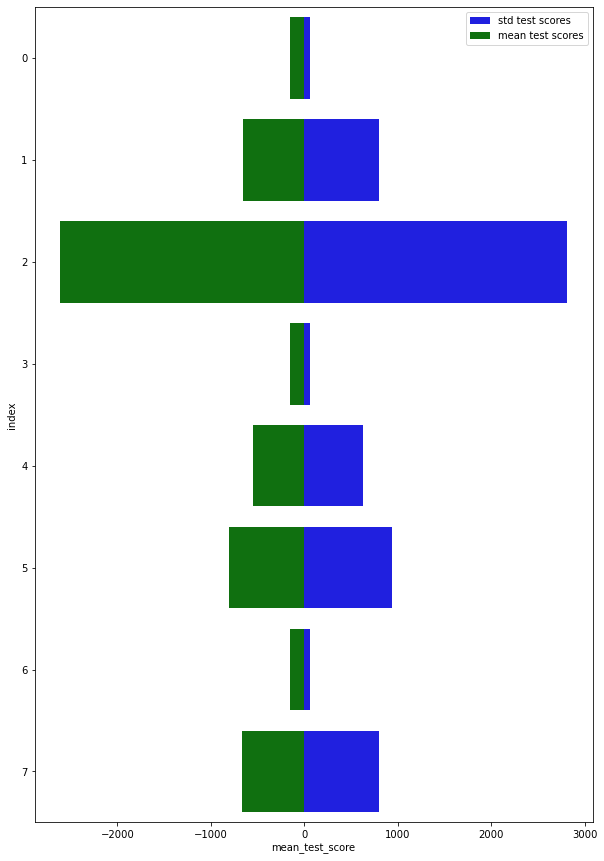

In [167]:
_compare_bar(train_params.iloc[0:-100])

In [54]:
print('Best params: ',grid_result.best_params_)

Best params:  {'C': 100, 'degree': 2, 'epsilon': 0.1, 'gamma': 0.01, 'kernel': 'linear'}


## Prepare Parameter Dictionary and Linear Regression() , SVR() with RandomizedSearchCV()

In [55]:
#LR
regression = { 'LR': LinearRegression(), 'SVR': SVR()}
fit_intercept = [True, False]
normalize = [True, False]
params_LR = dict( fit_intercept = fit_intercept, normalize = normalize) ,

#SVR
kernel = ["linear",'rbf', 'poly']
C_list = list(np.linspace(50, 2000, 100, dtype = float))
ep_list = list(np.linspace(0.1, 10, 100, dtype = float))
gamma = list(np.linspace(0.01, 0.1, 100, dtype = float))
degree = [2, 3]

params_SVR = dict( kernel = kernel, C = C_list, epsilon = ep_list, gamma = gamma, degree = degree )

In [56]:
for EST in regression:
    model = regression[EST]
    if (EST == 'LR'):
        params = params_LR
    else:
        params = params_SVR

randcv = RandomizedSearchCV(
    estimator=model, 
    n_jobs = -1,     
    verbose = 1,
    cv = 2,
    scoring = "neg_mean_squared_error",
    param_distributions = params ,
    n_iter=200,
    
)

In [57]:
randcv_result = randcv.fit(X_train, Y_train)

Fitting 2 folds for each of 200 candidates, totalling 400 fits


In [58]:
# Pack Result dataframe
train_randGrid=pd.DataFrame(randcv_result.cv_results_)[["params" ,"mean_test_score" ,"std_test_score","rank_test_score"]]
train_randGrid.sort_values(by=["rank_test_score"]).head()

,params,mean_test_score,std_test_score,rank_test_score
166,"{'kernel': 'linear', 'gamma': 0.07272727272727...",-1213.283462,809.444619,1
161,"{'kernel': 'linear', 'gamma': 0.03000000000000...",-1243.934722,828.365511,2
1,"{'kernel': 'linear', 'gamma': 0.02272727272727...",-1263.068020,828.911690,3
115,"{'kernel': 'linear', 'gamma': 0.06090909090909...",-1279.593319,844.481925,4
120,"{'kernel': 'linear', 'gamma': 0.07818181818181...",-1302.964164,879.878693,5


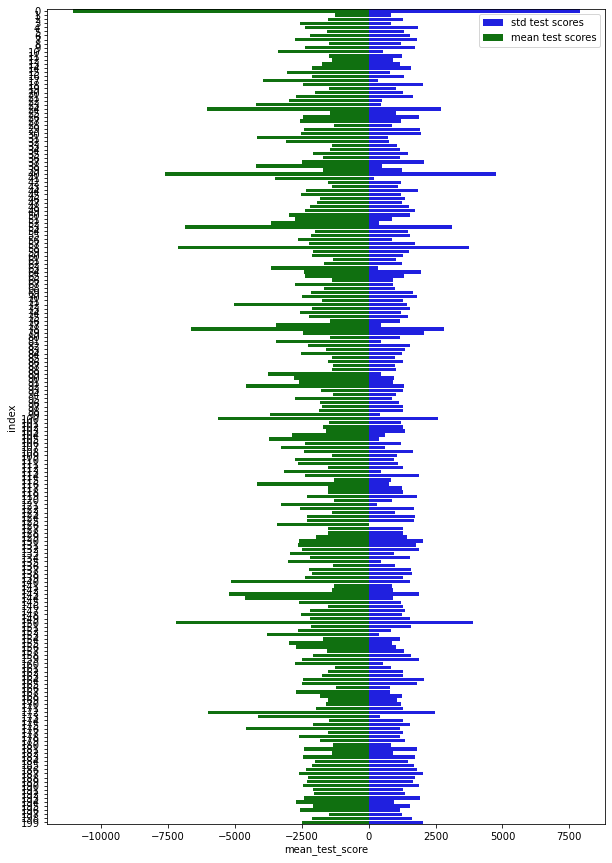

In [139]:
_compare_bar(train_randGrid)

# Prediction part

In [59]:
# Prediction with gridCV params
grid_model =SVR(C=100, degree=2, epsilon=1, gamma=0.01, kernel='linear')
grid_model.fit(X_train,Y_train)

SVR(C=100, degree=2, epsilon=1, gamma=0.01, kernel='linear')

In [60]:
# Prediction with RandCV params
rand_model = SVR(C=798.4848484848484, degree=2, epsilon=0.2, gamma=0.07181818181818182,kernel='linear')
rand_model.fit(X_train,Y_train)

SVR(C=798.4848484848484, degree=2, epsilon=0.2, gamma=0.07181818181818182,
    kernel='linear')

In [61]:
grid_predictions = grid_model.predict(X_test)
rand_predictions = rand_model.predict(X_test)

In [62]:
# define root mean squre error
def _myrmse(predictions) :
    rmse = np.sqrt( np.mean(predictions  - Y_test.values) ** 2 )
    return rmse

<AxesSubplot:>

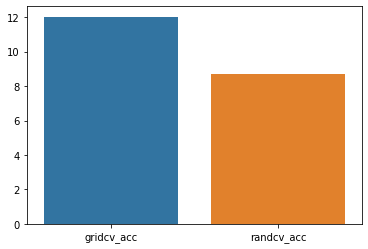

In [63]:
# Get RMSE
gridcv_acc = _myrmse(grid_predictions)
randcv_acc = _myrmse(rand_predictions)
acc=np.array([gridcv_acc ,randcv_acc]).reshape(1,-1)
acc_df = pd.DataFrame(acc ,columns=["gridcv_acc" ,"randcv_acc"])
sns.barplot(data=acc_df)

In [64]:
# Plot data
train_len = len(Y_train)
test_len = len(Y_test)
train = Y[:train_len]
valid = Y[train_len:]
valid["grid_predictions"] = grid_predictions
valid["rand_predictions"] = rand_predictions

In [65]:
ins = Base.reset_index(drop=True)

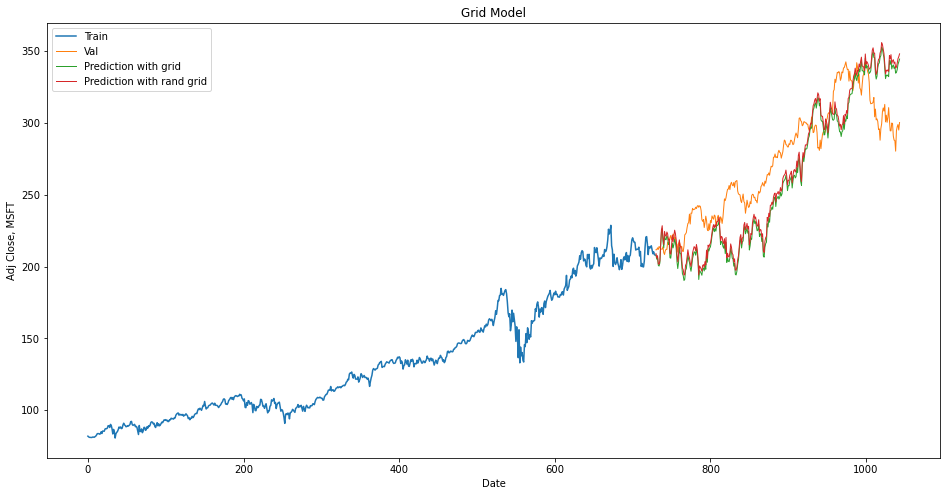

In [159]:
# Visualize 
plt.figure(figsize=(16,8))
plt.title("Grid Model")
plt.xlabel("Date")
plt.ylabel("Adj Close, MSFT")
plt.plot(train )
plt.plot(valid ,lw=1)
#plt.plot(RealData)
plt.legend(['Train' ,'Val','Prediction with grid' ,'Prediction with rand grid'])

# Example for plotly

In [202]:
import plotly.express as px
import plotly.graph_objects as go

In [304]:
m_x = idx_data[["SP500" , "DJIA"]]
y_x = stk_data.loc[:, ('Adj Close', 'MSFT')]
m_x.dropna(how="any",inplace=True )
y_x =y_x[:-1]

m_x = m_x[0:-200]
y_x = y_x[0:-200]

In [305]:
#prepare fortest

# Condition the model on sepal width and length, predict the petal width
mesh_model = SVR(C=1.)
mesh_model.fit(m_x, y_x)

SVR()

In [306]:
mesh_size = .02
margin = 0
# Create a mesh grid on which we will run our model
x_min, x_max = m_x.SP500.min() - margin, m_x.SP500.max() + margin
y_min, y_max = m_x.DJIA.min() - margin, m_x.DJIA.max() + margin
xrange = np.arange(x_min, x_max, mesh_size)
yrange = np.arange(y_min, y_max, mesh_size)
xx, yy = np.meshgrid(xrange, yrange)
np.c_[xx.ravel(), yy.ravel()].shape

MemoryError: Unable to allocate 602. GiB for an array with shape (809292, 99761) and data type float64

In [220]:
# Generate the plot
fig = px.scatter_3d(X, x='DEXJPUS', y='SP500', z='VIXCLS')
fig.update_traces(marker=dict(size=5))

# Run model


fig.add_traces(go.Surface(x=xrange, y=xrange, name='pred_surface'))
fig.show()